In [126]:
import numpy as np
import pandas as pd
import pickle
#import seaborn as sns
import matplotlib.pyplot as plt

In [127]:
#Retrieve pickle object
fileObj = open('data_algos.pkl', 'rb')
all_generations = pickle.load(fileObj)
fileObj.close()

In [128]:
generations_df = pd.DataFrame(all_generations)
generations_df.sample(8)

,radius,generation,fitness,selection_type,pop_size,mutation
240462,7.529412,259,0.002746,Ranked Selection,50,0.000
701903,1.647059,330,0.018701,Random Selection,80,0.001
1574733,1.647059,343,0.018701,Wheel Selection,40,0.010
2234481,2.000000,237,0.018138,Wheel Selection,80,0.050
1048682,1.764706,181,0.018668,Wheel Selection,70,0.001
1975726,5.529412,314,0.004927,Ranked Selection,50,0.050
1274637,1.882353,270,0.018471,Random Selection,80,0.010
2467408,20.705882,348,0.000371,Random Selection,90,0.100


## Impact of Population size and Mutation rates on results 

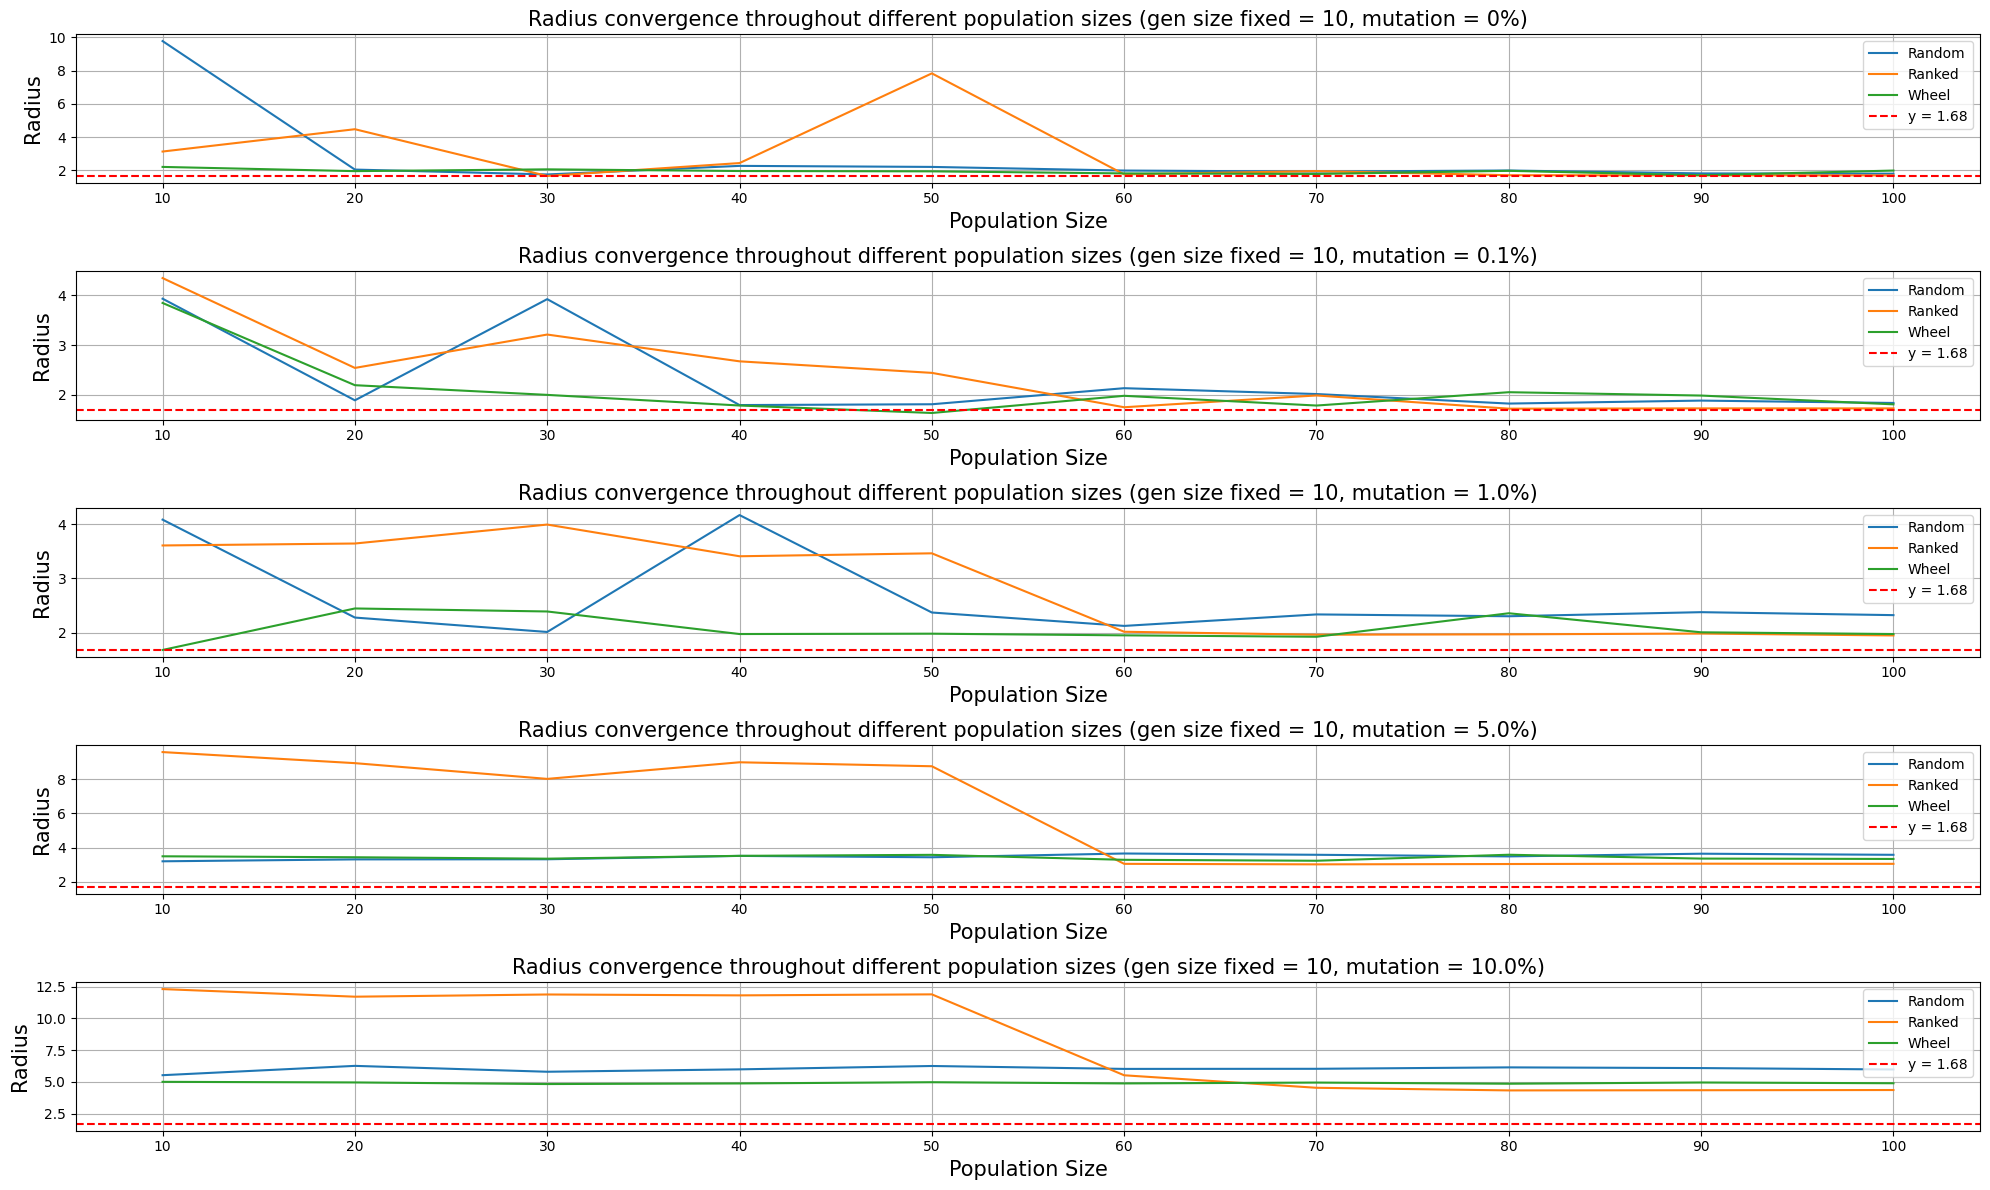

In [129]:
#Visualising the impact of pop_size on results
mutation_rates = [0, 0.001, 0.01, 0.05, 0.1]

# Define a function to create subplots for a given mutation rate
def pop_subplot(mutation_rate, subplot_index):
    mutation_df = generations_df[generations_df['mutation'] == mutation_rate]
    grouped_pop = mutation_df.groupby(by=['selection_type', 'pop_size']).mean()
    gen_size = len(grouped_pop.loc['Random Selection', 'radius'])
    x1 = range(gen_size)
    y1 = grouped_pop.loc['Random Selection', 'radius']
    y2 = grouped_pop.loc['Ranked Selection', 'radius']
    y3 = grouped_pop.loc['Wheel Selection', 'radius']

    plt.subplot(5, 1, subplot_index)
    plt.title(f'Radius convergence throughout different population sizes (gen size fixed = {gen_size}, mutation = {mutation_rate * 100}%)', fontsize=15)
    plt.xlabel('Population Size', fontsize=15)
    plt.ylabel('Radius', fontsize=15)

    plt.plot(x1, y1, label='Random')
    plt.plot(x1, y2, label='Ranked')
    plt.plot(x1, y3, label='Wheel')

    plt.grid()
    plt.axhline(y=1.6841, color='r', linestyle='--', label='y = 1.68')
    plt.legend()

    plt.xticks(range(len(grouped_pop.loc['Random Selection', 'radius'])), labels=grouped_pop.loc['Random Selection', 'radius'].index)


# Create subplots using a for loop
plt.rcParams["figure.figsize"] = (20, 12)
i=1
for mutation_rate in mutation_rates:
    pop_subplot(mutation_rate, i)
    i+=1

plt.tight_layout()
plt.show()


Methods are generally all converging when the population size reaches 60 individuals. Adding more individuals doesn't notably impact the outcome.

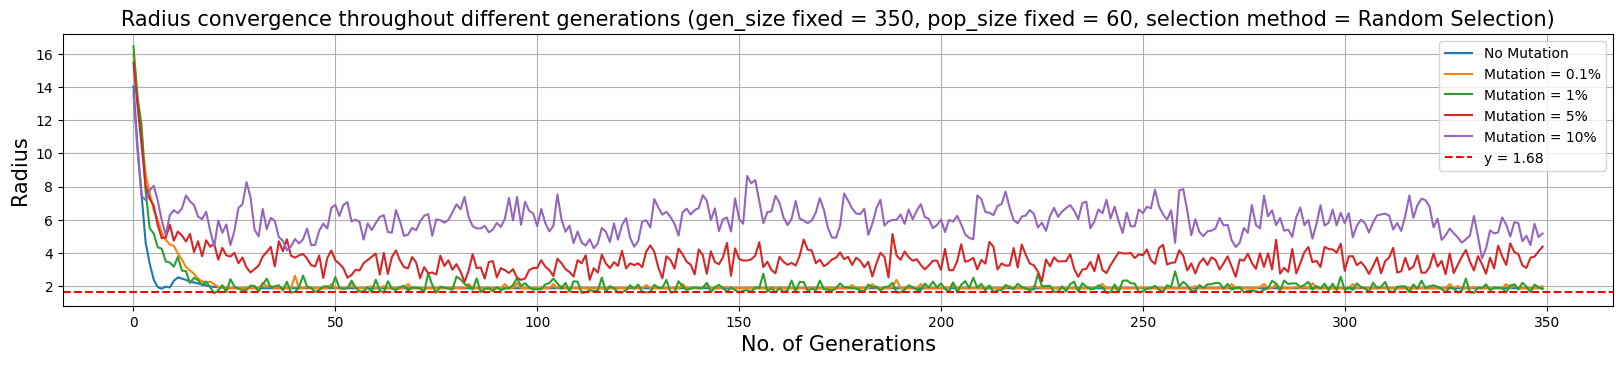

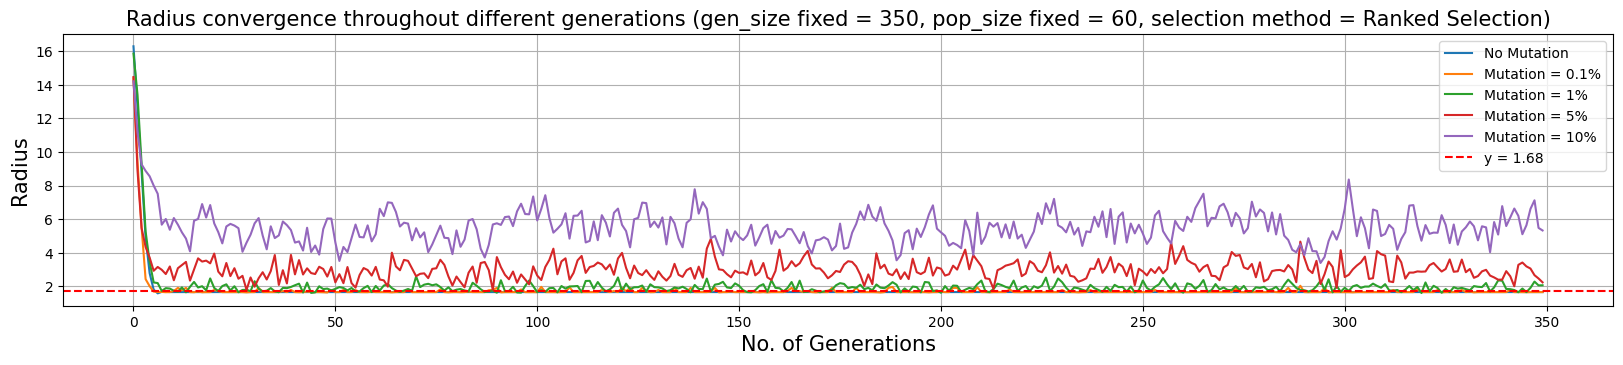

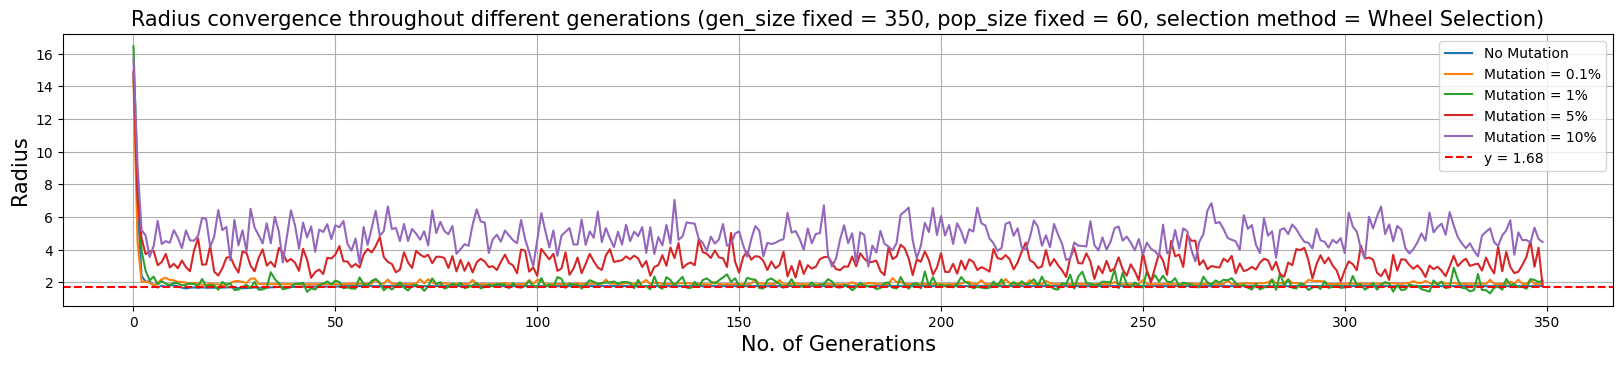

<Figure size 2000x1200 with 0 Axes>

In [130]:
#Visualising the results of different mutation rates on the population
#1. Filtering data by optimal population size
ideal_pop_size = 60
mutation_generations_df= generations_df[generations_df['pop_size']== ideal_pop_size]
selection_methods=['Random Selection','Ranked Selection','Wheel Selection']

# Define a function to create subplots for a given selection method
def sel_subplot(selection, subplot_index):
    mutation_generations_method_df= mutation_generations_df[mutation_generations_df['selection_type']==selection]
    grouped_pop = mutation_generations_method_df.groupby(by=['mutation','generation','selection_type']).mean()
    #indices = np.array(list(grouped_pop['radius'].index)).transpose()
    #cutoff_point = list(indices[0]).index(0.001) #find the generation size for the plot
    cutoff_point=350

    x1 = range(cutoff_point)
    y1 = (grouped_pop['radius'].values)[:cutoff_point]
    y2 = (grouped_pop['radius'].values)[cutoff_point:2*cutoff_point]
    y3 = (grouped_pop['radius'].values)[2*cutoff_point:3*cutoff_point]
    y4 = (grouped_pop['radius'].values)[3*cutoff_point:4*cutoff_point]
    y5 = (grouped_pop['radius'].values)[4*cutoff_point:]

    plt.subplot(3,1, subplot_index)
    plt.title(f'Radius convergence throughout different generations (gen_size fixed = {cutoff_point}, pop_size fixed = {ideal_pop_size}, selection method = {selection})',fontsize=15)
    plt.xlabel('No. of Generations',fontsize=15)
    plt.ylabel('Radius',fontsize=15)

    plt.plot(x1,y1, label = 'No Mutation') 
    plt.plot(x1,y2,label = 'Mutation = 0.1%')
    plt.plot(x1,y3,label = 'Mutation = 1%') 
    plt.plot(x1,y4, label = 'Mutation = 5%')  
    plt.plot(x1,y5, label = 'Mutation = 10%')


    plt.grid()

    plt.axhline(y=1.6841, color='r', linestyle='--', label='y = 1.68')
    #plt.xticks(range(len(grouped_pop.loc['Random Selection', 'radius'])), labels=grouped_pop.loc['Random Selection', 'radius'].index)
    plt.legend()

    plt.show()
    plt.close()
    

# Create subplots using a for loop
plt.rcParams["figure.figsize"] = (20, 12)
i=1
for selection in selection_methods:
    sel_subplot(selection, i)
    i+=1

plt.tight_layout()
plt.show()

Mutations exceeding 1% introduce too much variability, becoming counterproductive to the results.

# ERROR ANALYSIS
## Calculating the MSE

In [131]:
ideal_pop_size = 60
solution = 1.6841
mutation_rates = [0, 0.001, 0.01, 0.05, 0.1]
number_of_generations = 20
selection_types = ['Random Selection', 'Ranked Selection', 'Wheel Selection']

# Dictionary to memorize MSE for each mutation rate and selection type
mse_results = {rate: {sel_type: [] for sel_type in selection_types} for rate in mutation_rates}

for mutation_rate in mutation_rates:
    filtered_generations_df = generations_df[(generations_df['pop_size'] == ideal_pop_size) & (generations_df['mutation'] == mutation_rate)]

    for selection_type in selection_types:
        selected_df = filtered_generations_df[filtered_generations_df['selection_type'] == selection_type]
        MSES = []

        for k in range(number_of_generations):
            gen_df = selected_df[selected_df['generation'] == k]
            squared_errors = (gen_df['radius'] - solution) ** 2
            MSE = sum(squared_errors) / ideal_pop_size
            MSES.append(MSE)

        mse_results[mutation_rate][selection_type] = MSES

#Seeing the results
for mutation in mutation_rates:
    print(f"Mutation rate {mutation}:")
    for selection in selection_types:
        print(f"{selection} MSE: {mse_results[mutation][selection][-1]} (Gen {number_of_generations})")
    print("\n" + "-"*40 + "\n")


Mutation rate 0:
Random Selection MSE: 0.09910944206459059 (Gen 20)
Ranked Selection MSE: 0.00137204875432526 (Gen 20)
Wheel Selection MSE: 0.019006097197231835 (Gen 20)

----------------------------------------

Mutation rate 0.001:
Random Selection MSE: 1.3746676888927338 (Gen 20)
Ranked Selection MSE: 0.00137204875432526 (Gen 20)
Wheel Selection MSE: 0.2821505262629758 (Gen 20)

----------------------------------------

Mutation rate 0.01:
Random Selection MSE: 1.2569209299538637 (Gen 20)
Ranked Selection MSE: 11.516867896505191 (Gen 20)
Wheel Selection MSE: 3.8284626831257196 (Gen 20)

----------------------------------------

Mutation rate 0.05:
Random Selection MSE: 26.863701506655126 (Gen 20)
Ranked Selection MSE: 15.706479822687426 (Gen 20)
Wheel Selection MSE: 28.160554378627452 (Gen 20)

----------------------------------------

Mutation rate 0.1:
Random Selection MSE: 44.04696494379469 (Gen 20)
Ranked Selection MSE: 75.88838106836216 (Gen 20)
Wheel Selection MSE: 25.98669022

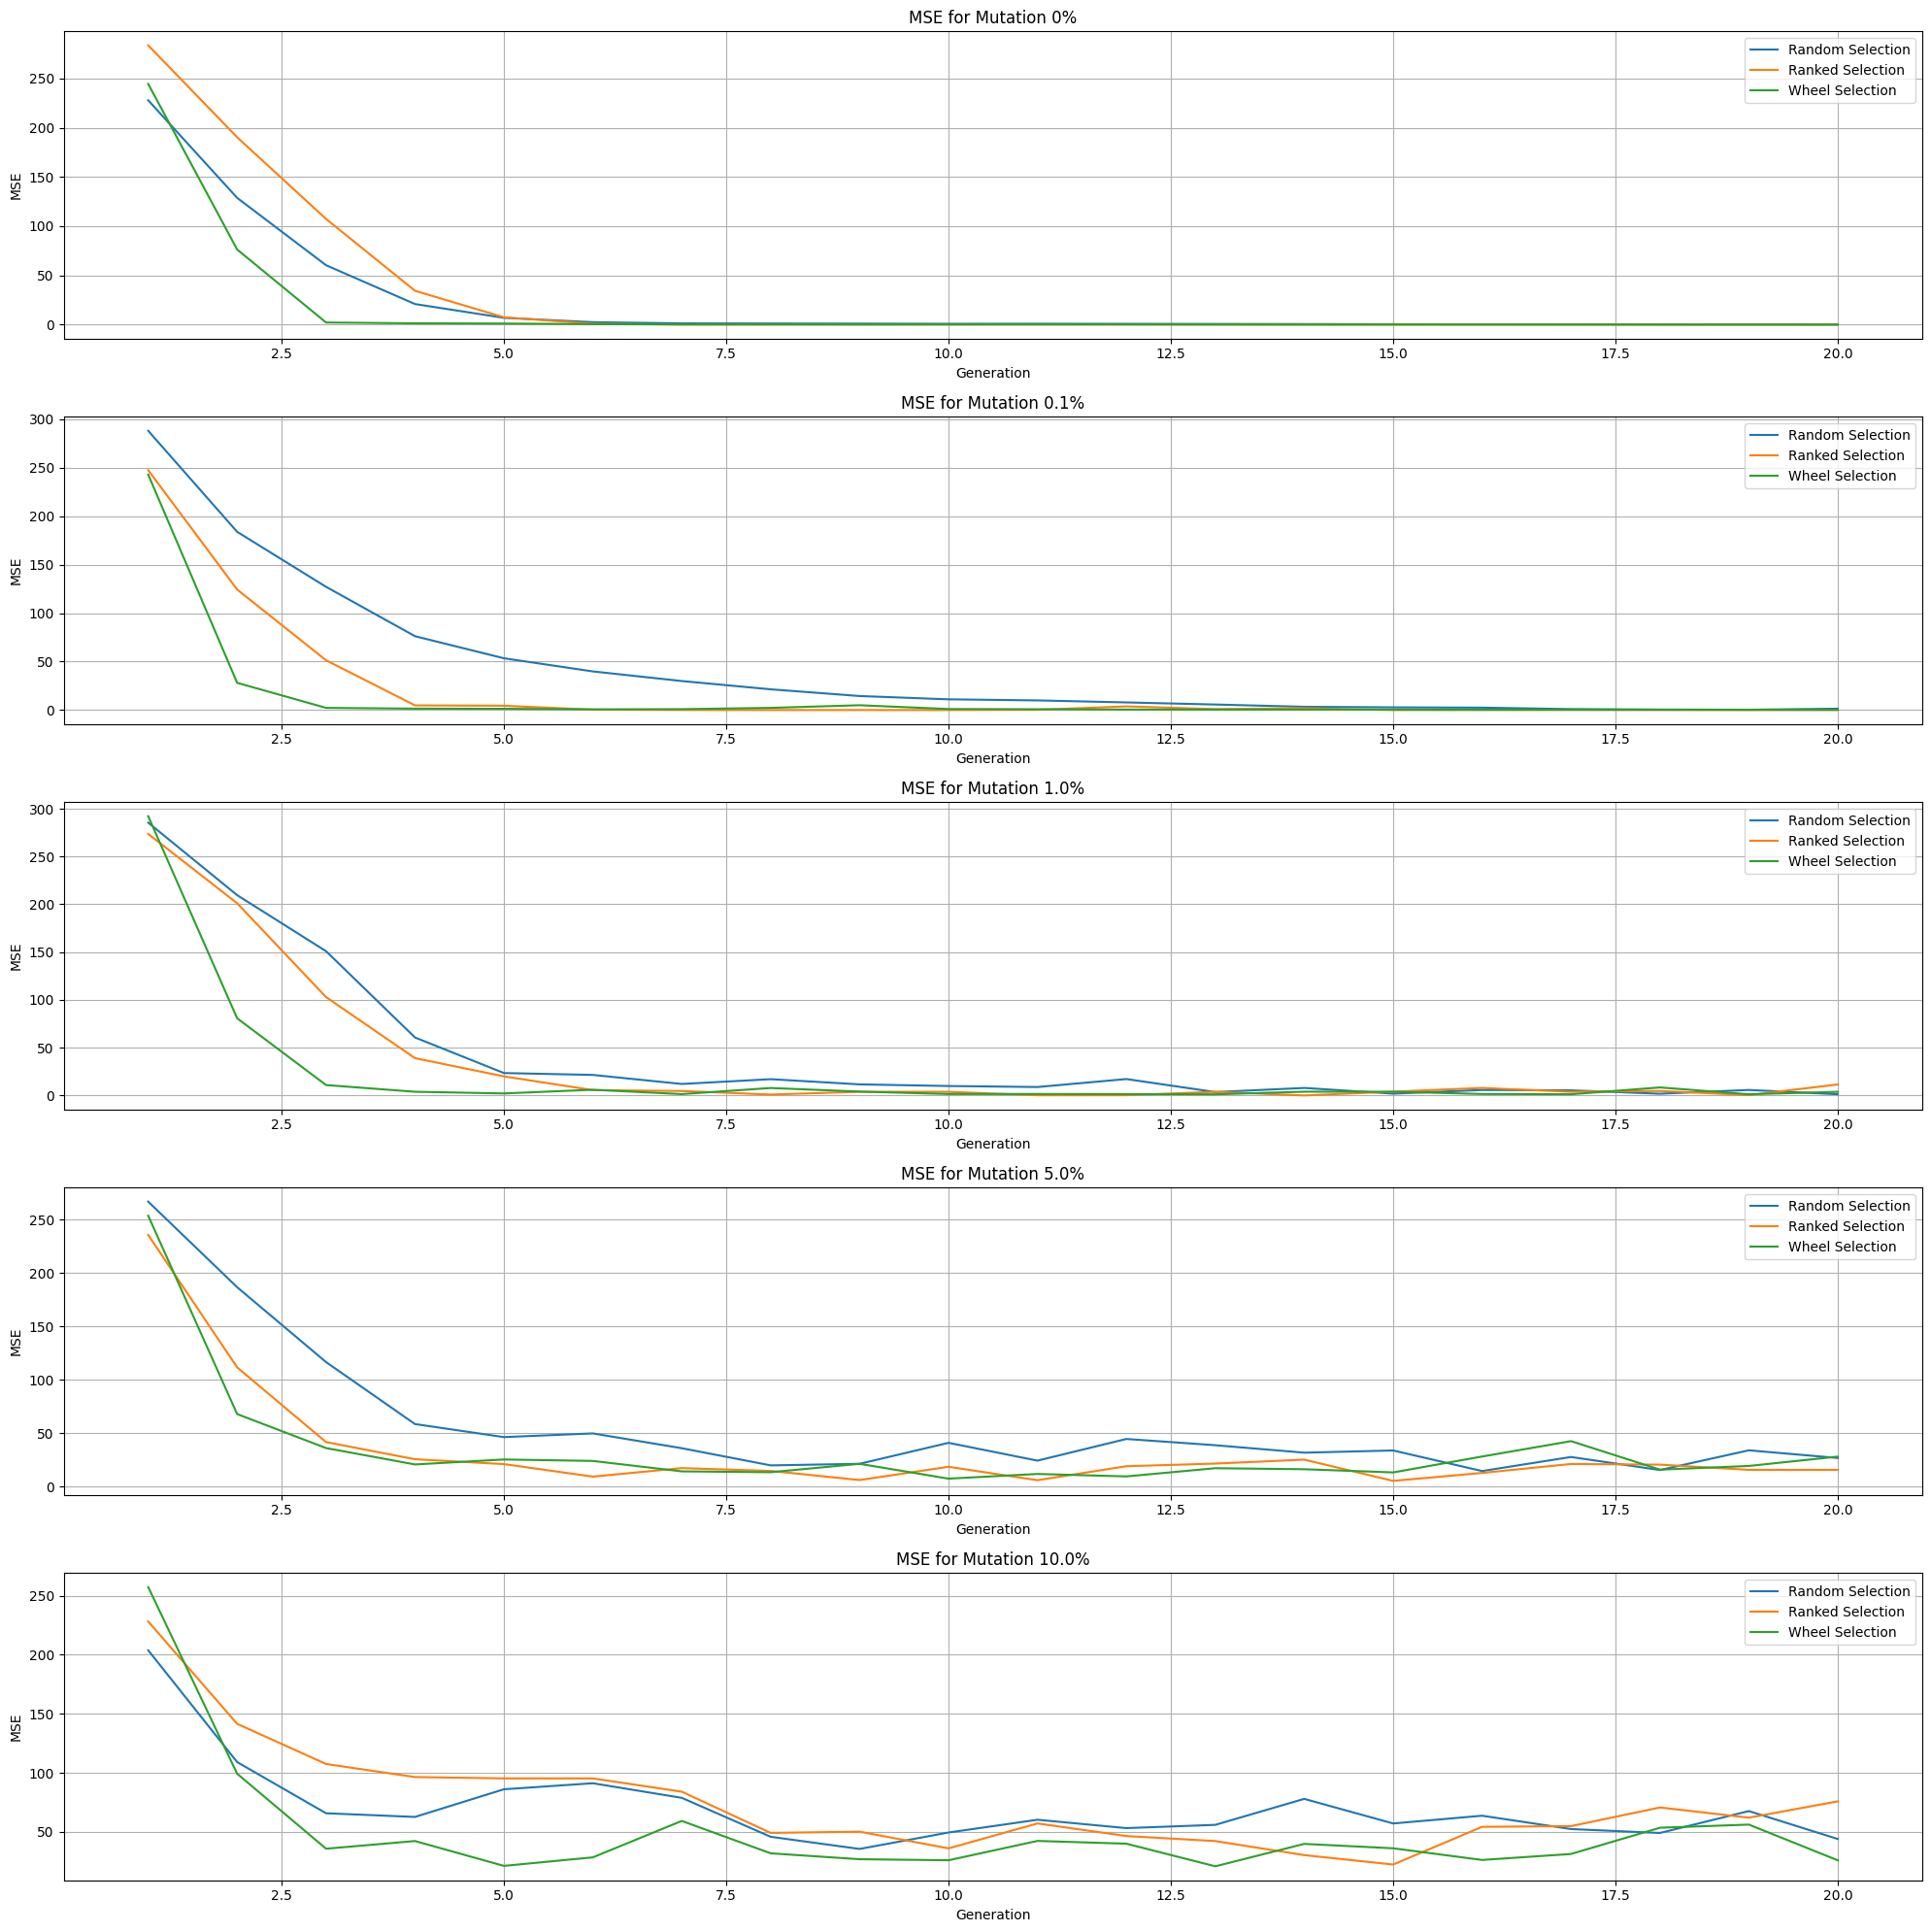

In [132]:
# Plotting the results
plt.rcParams["figure.figsize"] = (20, 20)
i=1
for mutation_rate in mutation_rates:
    plt.subplot(5,1,i)
    plt.plot(range(1, number_of_generations+1), mse_results[mutation_rate]['Random Selection'], label='Random Selection')
    plt.plot(range(1, number_of_generations+1), mse_results[mutation_rate]['Ranked Selection'], label='Ranked Selection')
    plt.plot(range(1, number_of_generations+1), mse_results[mutation_rate]['Wheel Selection'], label='Wheel Selection')

    plt.title(f'MSE for Mutation {mutation_rate*100}%')
    plt.xlabel('Generation')
    plt.ylabel('MSE')
    plt.legend()
    plt.grid()

    i+=1
plt.tight_layout()
plt.show()


# 
START OF IDK THINGS


In [133]:
#creating one DataFrame for each selection method
generations_df = pd.DataFrame(all_generations)
new_generations_df=generations_df[generations_df['mutation']==0]
#checking the results
new_generations_df.sample(5)

,radius,generation,fitness,selection_type,pop_size,mutation
318713,1.647059,2,0.018701,Ranked Selection,90,0.0
8032,1.882353,226,0.018471,Random Selection,20,0.0
94889,1.764706,305,0.018668,Random Selection,70,0.0
318849,1.647059,3,0.018701,Ranked Selection,90,0.0
296619,1.647059,76,0.018701,Ranked Selection,80,0.0


In [134]:
#Sample Statistics
new_generations_df.groupby(by=['selection_type', 'generation']).describe(percentiles = [0.5])


radius                                            \
                             count       mean       std       min        50%   
selection_type   generation                                                    
Random Selection 0           550.0  14.932620  8.696517  0.117647  14.705882   
                 1           550.0  11.780107  7.059925  0.117647  11.411765   
                 2           550.0   9.089840  5.493503  0.117647   9.058824   
                 3           550.0   7.181176  4.481243  0.117647   7.529412   
                 4           550.0   5.922995  3.806152  0.117647   5.647059   
...                            ...        ...       ...       ...        ...   
Wheel Selection  345         550.0   1.844920  0.121890  1.647059   1.882353   
                 346         550.0   1.845134  0.122059  1.647059   1.882353   
                 347         550.0   1.844920  0.121890  1.647059   1.882353   
                 348         550.0   1.845134  0.122059  1.647059   1.882353   
                 349         550.0   1.844492  0.121551  1.647059   1.882353   

                                       fitness                                \
                                   max   count      mean       std       min   
selection_type   generation                                                    
Random Selection 0           30.000000   550.0  0.002926  0.004742  0.000177   
                 1           28.823529   550.0  0.003907  0.005396  0.000191   
                 2           28.352941   550.0  0.004892  0.005644  0.000198   
                 3           30.000000   550.0  0.005927  0.005788  0.000177   
                 4           23.176471   550.0  0.007308  0.006069  0.000296   
...                                ...     ...       ...       ...       ...   
Wheel Selection  345          2.117647   550.0  0.018472  0.000228  0.017696   
                 346          2.117647   550.0  0.018471  0.000229  0.017696   
                 347          2.117647   550.0  0.018472  0.000228  0.017696   
                 348          2.117647   550.0  0.018471  0.000229  0.017696   
                 349          2.117647   550.0  0.018473  0.000227  0.017696   

                             ...   pop_size                    mutation       \
                             ...        std   min   50%    max    count mean   
selection_type   generation  ...                                               
Random Selection 0           ...  24.517196  10.0  70.0  100.0    550.0  0.0   
                 1           ...  24.517196  10.0  70.0  100.0    550.0  0.0   
                 2           ...  24.517196  10.0  70.0  100.0    550.0  0.0   
                 3           ...  24.517196  10.0  70.0  100.0    550.0  0.0   
                 4           ...  24.517196  10.0  70.0  100.0    550.0  0.0   
...                          ...        ...   ...   ...    ...      ...  ...   
Wheel Selection  345         ...  24.517196  10.0  70.0  100.0    550.0  0.0   
                 346         ...  24.517196  10.0  70.0  100.0    550.0  0.0   
                 347         ...  24.517196  10.0  70.0  100.0    550.0  0.0   
                 348         ...  24.517196  10.0  70.0  100.0    550.0  0.0   
                 349         ...  24.517196  10.0  70.0  100.0    550.0  0.0   

                                                 
                             std  min  50%  max  
selection_type   generation                      
Random Selection 0           0.0  0.0  0.0  0.0  
                 1           0.0  0.0  0.0  0.0  
                 2           0.0  0.0  0.0  0.0  
                 3           0.0  0.0  0.0  0.0  
                 4           0.0  0.0  0.0  0.0  
...                          ...  ...  ...  ...  
Wheel Selection  345         0.0  0.0  0.0  0.0  
                 346         0.0  0.0  0.0  0.0  
                 347         0.0  0.0  0.0  0.0  
                 348         0.0  0.0  0.0  0.0  
               

In [135]:
new_generations_df.groupby(by=['selection_type', 'pop_size']).describe(percentiles = [0.5])

radius                                          \
                             count      mean       std       min       50%   
selection_type   pop_size                                                    
Random Selection 10         3500.0  9.778487  0.511154  0.352941  9.764706   
                 20         7000.0  2.042101  1.374762  0.117647  1.882353   
                 30        10500.0  1.748751  1.210188  0.117647  1.647059   
                 40        14000.0  2.265000  1.236122  0.235294  2.117647   
                 50        17500.0  2.202158  1.574906  0.117647  2.000000   
                 60        21000.0  1.982818  1.118299  0.117647  1.882353   
                 70        24500.0  1.922084  1.294870  0.117647  1.764706   
                 80        28000.0  1.986105  1.191236  0.117647  1.882353   
                 90        31500.0  1.811899  1.447163  0.117647  1.647059   
                 100       35000.0  1.794484  1.316945  0.117647  1.647059   
Ranked Selection 10         3500.0  3.128168  1.471118  2.000000  2.941176   
                 20         7000.0  4.471983  1.354715  0.117647  4.352941   
                 30        10500.0  1.656717  2.832393  0.470588  0.941176   
                 40        14000.0  2.434168  2.467717  0.352941  1.882353   
                 50        17500.0  7.834071  1.744969  0.117647  7.529412   
                 60        21000.0  1.753776  1.334271  0.117647  1.647059   
                 70        24500.0  1.950151  0.985818  0.235294  1.882353   
                 80        28000.0  1.702924  0.954875  0.117647  1.647059   
                 90        31500.0  1.695492  0.933164  0.117647  1.647059   
                 100       35000.0  1.691869  0.872696  0.117647  1.647059   
Wheel Selection  10         3500.0  2.202319  1.119050  1.294118  2.117647   
                 20         7000.0  1.948303  0.805369  1.882353  1.882353   
                 30        10500.0  2.055955  0.874676  0.117647  2.000000   
                 40        14000.0  1.955176  0.978431  0.117647  1.882353   
                 50        17500.0  1.935489  0.925426  0.117647  1.882353   
                 60        21000.0  1.811557  0.962528  0.117647  1.764706   
                 70        24500.0  1.776898  0.952781  0.117647  1.764706   
                 80        28000.0  1.967445  0.949172  0.117647  1.882353   
                 90        31500.0  1.699634  1.014090  0.235294  1.647059   
                 100       35000.0  1.982524  0.924608  0.117647  1.882353   

                                     generation                          ...  \
                                 max      count   mean         std  min  ...   
selection_type   pop_size                                                ...   
Random Selection 10        26.823529     3500.0  174.5  101.050322  0.0  ...   
                 20        29.882353     7000.0  174.5  101.043102  0.0  ...   
                 30        29.294118    10500.0  174.5  101.040696  0.0  ...   
                 40        28.235294    14000.0  174.5  101.039493  0.0  ...   
                 50        30.000000    17500.0  174.5  101.038772  0.0  ...   
                 60        28.352941    21000.0  174.5  101.038290  0.0  ...   
                 70        29.882353    24500.0  174.5  101.037947  0.0  ...   
                 80        29.294118    28000.0  174.5  101.037689  0.0  ...   
                 90        29.764706    31500.0  174.5  101.037488  0.0  ...   
                 100       30.000000    35000.0  174.5  101.037328  0.0  ...   
Ranked Selection 10        29.764706     3500.0  174.5  101.050322  0.0  ...   
                 20        29.176471     7000.0  174.5  101.043102  0.0  ...   
                 30        29.411765    10500.0  174.5  101.040696  0.0  ...   
                 40        30.000000    14000.0  174.5  101.039493  0.0  ...   
                 50        30.000000    17500.0  174.5  101.038772  0.0  ...   
             

In [136]:
grouped_pop.loc['Random Selection', 'radius'].values

NameError: name 'grouped_pop' is not defined

WITH MUTATIONS

In [ ]:
mutation_generations_df=generations_df[generations_df['mutation']!=0]
#checking the results
mutation_generations_df.sample(5)

In [ ]:
#Sample Statistics
mutation_generations_df.groupby(by=['selection_type', 'generation']).describe(percentiles = [0.5])

In [ ]:
grouped = mutation_generations_df.groupby(by=['selection_type', 'generation']).mean()
#create plots

plt.rcParams["figure.figsize"]=(20,12)

x1 = range(len(grouped.loc['Random Selection', 'fitness']))
y1 = grouped.loc['Random Selection', 'radius']
y2 = grouped.loc['Ranked Selection', 'radius']
y3 = grouped.loc['Wheel Selection', 'radius']

plt.title('Radius convergence throught the generations (population size fixed)',fontsize=15)
plt.xlabel('Generation Number',fontsize=15)
plt.ylabel('Radius',fontsize=15)

plt.plot(x1,y1,label = 'Random')
plt.plot(x1,y2,label = 'Ranked') 
plt.plot(x1,y3, label = 'Wheel')  
plt.grid()
plt.axhline(y=1.6841, color='r', linestyle='--', label='y = 1.68')
plt.legend()

plt.show()

In [ ]:
grouped = mutation_generations_df.groupby(by=['selection_type', 'generation']).mean()
#create plots

plt.rcParams["figure.figsize"]=(20,12)

x1 = range(len(grouped.loc['Random Selection', 'fitness']))
y1 = grouped.loc['Random Selection', 'fitness']
y2 = grouped.loc['Ranked Selection', 'fitness']
y3 = grouped.loc['Wheel Selection', 'fitness']

plt.title('Fitness convergence throught the generations (population size fixed)',fontsize=15)
plt.xlabel('Generation Number',fontsize=15)
plt.ylabel('Fitness',fontsize=15)

plt.plot(x1,y1,label = 'Random')
plt.plot(x1,y2,label = 'Ranked') 
plt.plot(x1,y3, label = 'Wheel')  
plt.grid()
plt.legend()
plt.axhline(y=0.018709891942760622, color='r', linestyle='--', label='y = 0,0187')

plt.show()

In [ ]:
#mutation_generations_df=generations_df[generations_df['mutation']!=0]
mutation_generations_df=generations_df
#mutation_generations_df= mutation_generations_df[mutation_generations_df['selection_type']=='Ranked Selection']
mutation_generations_df= mutation_generations_df[mutation_generations_df['pop_size']== 60]
mutation_generations_df.head()

In [ ]:
grouped_pop = mutation_generations_df.groupby(by=['mutation','generation']).mean()
grouped_pop

In [ ]:
fuck_you = np.array(list(grouped_pop['radius'].index)).transpose()
fuck_you[0]

In [ ]:
list(fuck_you[0]).index(0.001)

In [ ]:
grouped_pop = mutation_generations_df.groupby(by=['selection_type', 'generation']).mean()
#create plots

plt.rcParams["figure.figsize"]=(20,12)

x1 = range(len(grouped_pop['mutation'] == 0.001))
y1 = grouped_pop[grouped_pop['mutation'] == 0.001].loc['Random Selection', 'radius']
y2 = grouped_pop[grouped_pop['mutation'] == 0.01].loc['Random Selection', 'radius']
y3 = grouped_pop[grouped_pop['mutation'] == 0.1].loc['Random Selection', 'radius']
y4 = grouped_pop[grouped_pop['mutation'] == 0.05].loc['Random Selection', 'radius']

plt.title('Radius convergence throughout different population sizes (generation size fixed = 500)',fontsize=15)
plt.xlabel('Population Size',fontsize=15)
plt.ylabel('Radius',fontsize=15)

plt.plot(x1,y1,label = '0.1%')
plt.plot(x1,y2,label = '1%') 
plt.plot(x1,y3, label = '10%') 
plt.plot(x1,y4, label = '5%')  

plt.grid()
plt.axhline(y=1.6841, color='r', linestyle='--', label='y = 1.68')
plt.legend()

plt.xticks(range(len(grouped_pop.loc['Random Selection', 'radius'])), labels=grouped_pop.loc['Random Selection', 'radius'].index)
plt.show()